# CS 109A/AC 209A/STAT 121A Data Science: Homework 2
**Harvard University**<br>
**Fall 2016**<br>
**Instructors: W. Pan, P. Protopapas, K. Rader**<br>
**Due Date: ** Wednesday, September 21st, 2016 at 11:59pm

Download the `IPython` notebook as well as the data file from Vocareum and complete locally.

To submit your assignment, in Vocareum, upload (using the 'Upload' button on your Jupyter Dashboard) your solution to Vocareum as a single notebook with following file name format:

`last_first_CourseNumber_HW2.ipynb`

where `CourseNumber` is the course in which you're enrolled (CS 109a, Stats 121a, AC 209a). Submit your assignment in Vocareum using the 'Submit' button.

**Avoid editing your file in Vocareum after uploading. If you need to make a change in a solution. Delete your old solution file from Vocareum and upload a new solution. Click submit only ONCE after verifying that you have uploaded the correct file. The assignment will CLOSE after you click the submit button.**


Problems on homework assignments are equally weighted. The Challenge Question is required for AC 209A students and optional for all others. Student who complete the Challenge Problem as optional extra credit will receive +0.5% towards your final grade for each correct solution. 

Import libraries

In [1]:
import numpy as np
import pandas as pd
import random
import sklearn as sk
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.cross_validation import train_test_split as sk_split
from sklearn.linear_model import LinearRegression as Lin_Reg
import time
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

---

## Problem 0: Basic Information

Fill in your basic information. 

### Part (a): Your name

[Zambalayev, Timur]

### Part (b): Course Number

[CSCI E-109a]

### Part (c): Who did you work with?

[]

---

## Problem 1: Inside the Models in Scikit-learn

In this problem, we will be implementing K-Nearest Neighbour and simple linear regression for predicting a quantitative variable. We will compare the performance of our implementation with those of Scikit-learn (``sklearn``).

The datasets required for this problem is in the ``dataset`` directory. Each file in the ``dataset`` directory contains a one-dimensional data set, with the first column containing the independent variable X, and the second column containing the dependent variable Y. 

### Part (a): Implement the models by hand
In this part you **may not** use ``sklearn`` for any task.

In the following, you may use ``numpy`` arrays instead of ``pandas`` dataframes.

- Implement a function ``split``, which satifies:
    - input: an ``nx2`` dataframe ``data``, a float ``m``
    - return: an ``nx2`` dataframe ``train`` and an ``nx2`` dataframe ``test``, consisting of ``m`` percent and ``100 - m`` percent of the data, respectively.


- Implement K-Nearest Neighbour for predicting a quantitative variable. That is, write a function, ``knn_predict``, that satisfies:
    - input: an integer ``k``, an ``n x 2`` dataframe training set ``train``, an ``n x 1`` dataframe testing set ``test``
    - return: an ``nx2`` dataframe, whose first column is that of ``test`` and whose second column is the predicted values.



- Implement linear regression for predicting a quantitative variable. That is, write a function ``linear_reg_fit`` that satisfies:
    - input: an ``nx2`` dataframe training set ``train``
    - return: the coefficients of the linear regression model - a float ``slope`` and a float ``intercept``.
    
    
- Write a function ``linear_reg_predict`` that satisfies:
    - input: an ``nx1`` dataframe testing set ``test``, as well as the coefficients of the linear regression model
    - return: an ``nx2`` dataframe, whose first column is that of ``test`` and whose second column is the predicted values.
    
    
- Implement a function ``score`` that satisfies:
    - input: an ``nx2`` dataframe ``predicted``, an ``nx2`` dataframe ``actual`` 
    - return: R^2 coefficient of the fit of the predicted values.

**Solution:**

In [2]:
from collections import namedtuple

Range = namedtuple('Range', ['left', 'right'])


# split

def split(data, m):
    test_size = 1 - m
    length = len(data)

    indices = list(data.index)
    np.random.shuffle(indices)

    test_length = int(round(test_size * length))
    test_indices = indices[:test_length]
    train_indices = indices[test_length:]

    test = data.loc[test_indices]
    train = data.loc[train_indices]

    return train, test


# knn

def distance(x1, x2):
    return abs(x1 - x2)


def find_best_neighbors_range(sorted_x_list, neighbors_range, test_x):
    current_left_index, current_right_index = neighbors_range
    best_range = neighbors_range
    while current_right_index < len(sorted_x_list):
        left_distance = distance(test_x, sorted_x_list[current_left_index])
        right_distance = distance(test_x, sorted_x_list[current_right_index])
        if left_distance <= right_distance:
            break
        best_range = Range(current_left_index, current_right_index)
        current_left_index += 1
        current_right_index += 1

    if best_range.left == neighbors_range.left:
        # we didn't find better neighbors on the right, so we'll search left
        current_left_index = neighbors_range.left - 1
        current_right_index = neighbors_range.right - 1
        while current_left_index >= 0:
            left_distance = distance(test_x, sorted_x_list[current_left_index])
            right_distance = distance(test_x, sorted_x_list[current_right_index])
            if left_distance >= right_distance:
                break
            best_range = Range(current_left_index, current_right_index)
            current_left_index -= 1
            current_right_index -= 1
    return best_range


def get_initial_range(k, insertion_index, length):
    left_index = max(0, insertion_index - k / 2)
    right_index = left_index + k
    if right_index > length:
        right_index = length
        left_index = right_index - k
    return Range(left_index, right_index)


def find_nearest_neighbors(k, sorted_x_list, test_x):
    insertion_index = bisect.bisect_left(sorted_x_list, test_x)
    initial_range = get_initial_range(k, insertion_index, len(sorted_x_list))
    return find_best_neighbors_range(sorted_x_list, initial_range, test_x)


def knn_predict_one_point(k, sorted_x_list, sorted_y_list, test_x):
    neighbors_range = find_nearest_neighbors(k, sorted_x_list, test_x)
    total = sum(islice(sorted_y_list, *neighbors_range))
    return total / k


def knn_predict(k, train, test):
    sorted_train = train.sort_values(by='x')
    sorted_x_list = sorted_train['x'].values
    sorted_y_list = sorted_train['y'].values
    predicted_test = test.copy()

    predicted_test['y'] = [knn_predict_one_point(k, sorted_x_list, sorted_y_list, row['x'])
                           for _, row in test.iterrows()]
    return predicted_test


# linear regression

def linear_reg_fit(train):
    xs = train['x']
    ys = train['y']

    x_mean = xs.mean()
    y_mean = ys.mean()

    numerator_sum = 0.0
    denominator_sum = 0.0
    for x, y in izip(xs, ys):
        x_diff = x - x_mean
        numerator_sum += x_diff * (y - y_mean)
        denominator_sum += x_diff ** 2

    slope = numerator_sum / denominator_sum
    intercept = y_mean - slope * x_mean
    return slope, intercept


def linear_reg_predict(test, slope, intercept):
    predicted_test = test.copy()
    predicted_test['y'] = [intercept + slope * row['x'] for _, row in test.iterrows()]
    return predicted_test


# score

def score(predicted, actual):
    rss = 0.0
    tss = 0.0
    actual_y_list = actual['y']
    actual_y_mean = np.mean(actual_y_list)
    for predicted_value, actual_value in izip(predicted['y'], actual_y_list):
        rss += (actual_value - predicted_value) ** 2
        tss += (actual_value - actual_y_mean) ** 2
    return 1.0 - rss / tss

### Part (b): Compare with ``sklearn``

- Load the contents of ``dataset_1_full.txt`` into a ``pandas`` dataframe, or ``numpy`` array. 


- Use your functions from Part (a) to split the data into training and testing sets (70-30). Evaluate how KNN and linear regression each perform on this dataset.


- Use ``sklearn`` to split the data into training and testing sets (70-30). Use ``sklearn`` to evaluate how KNN and linear regression each perform on this dataset.


- Use Python's ``time`` library to measure how well your implementations compare with that of ``sklearn``. What can you do (algorithmically or codewise) to make your implementation faster or more efficient?

**Solution:**

In [3]:
import bisect
import itertools
from itertools import izip, islice


def generate_k_list():
    return list(itertools.chain(
        range(1, 6),
        range(10, 21, 5),
        range(30, 51, 10),
        range(75, 101, 25),
        range(150, 351, 50),
    ))


def evaluate_our_implementation(df, k_list):
    print 'our implementation'
    train, test = split(df, 0.7)

    test_x = test[['x']]
    for k in k_list:
        start = time.time()
        predicted_test = knn_predict(k, train, test_x)
        s = score(predicted_test, test)
        elapsed_time = time.time() - start
        print 'KNN, k: %d, score: %.3f, time: %.2f' % (k, s, elapsed_time)

    start = time.time()
    slope, intercept = linear_reg_fit(train)
    predicted_test = linear_reg_predict(test_x, slope, intercept)
    s = score(predicted_test, test)
    elapsed_time = time.time() - start
    print 'linear regression, score: %.3f, time: %.2f\n' % (s, elapsed_time)


def reshape(df, column_name):
    return df[column_name].reshape((-1, 1))


def evaluate_sklearn_implementation(df, k_list):
    print 'sklearn implementation'
    train, test = sk_split(df, train_size=0.7)

    x_train = reshape(train, 'x')
    y_train = reshape(train, 'y')
    x_test = reshape(test, 'x')
    y_test = reshape(test, 'y')
    for k in k_list:
        start = time.time()
        neighbors = KNN(n_neighbors=k)
        neighbors.fit(x_train, y_train)
        s = neighbors.score(x_test, y_test)
        elapsed_time = time.time() - start
        print 'KNN, k: %d, score: %.3f, time: %.2f' % (k, s, elapsed_time)

    start = time.time()
    regression = Lin_Reg()
    regression.fit(x_train, y_train)
    s = regression.score(x_test, y_test)
    elapsed_time = time.time() - start
    print 'linear regression, score: %.3f, time: %.2f' % (s, elapsed_time)


def compare_with_sklearn():
    np.random.seed(1090)

    df = pd.read_csv('dataset/dataset_1_full.txt')
    k_list = generate_k_list()

    evaluate_our_implementation(df, k_list)
    evaluate_sklearn_implementation(df, k_list)

    
compare_with_sklearn()

our implementation
KNN, k: 1, score: -0.396, time: 0.01
KNN, k: 2, score: -0.027, time: 0.00
KNN, k: 3, score: 0.205, time: 0.01
KNN, k: 4, score: 0.244, time: 0.01
KNN, k: 5, score: 0.266, time: 0.01
KNN, k: 10, score: 0.338, time: 0.00
KNN, k: 15, score: 0.342, time: 0.00
KNN, k: 20, score: 0.382, time: 0.01
KNN, k: 30, score: 0.417, time: 0.01
KNN, k: 40, score: 0.402, time: 0.01
KNN, k: 50, score: 0.421, time: 0.01
KNN, k: 75, score: 0.417, time: 0.01
KNN, k: 100, score: 0.413, time: 0.01
KNN, k: 150, score: 0.397, time: 0.01
KNN, k: 200, score: 0.364, time: 0.01
KNN, k: 250, score: 0.284, time: 0.01
KNN, k: 300, score: 0.181, time: 0.01
KNN, k: 350, score: -0.002, time: 0.01
linear regression, score: 0.418, time: 0.00

sklearn implementation
KNN, k: 1, score: -0.078, time: 0.00
KNN, k: 2, score: 0.177, time: 0.00
KNN, k: 3, score: 0.231, time: 0.00
KNN, k: 4, score: 0.259, time: 0.00
KNN, k: 5, score: 0.302, time: 0.00
KNN, k: 10, score: 0.327, time: 0.00
KNN, k: 15, score: 0.367,

***What can you do to make your implementation faster?***

My current implmentation is as fast is sklearn's at least on this dataset. 
The optimizations I made in comparison to a possible naive implementation were:
* I sorted the train dataframe by 'x' values so that it's easier/faster to locate k nearest neighbors. I used binary search to find the insertion point in the sorted array. Then I would start with a range of length k centered around that insertion point. Then I would try to improve that range by trying to move to the right and to the left.
* Another optimization I made is I passed individual sorted 'x' and 'y' value lists for the train set so that not to do dataframe indexing inside a very nested loop. It improved the performance dramatically.

## Problem 2: Handling Missing Data

In this problem, we will be handling the problem of datasets with missing values. Clearly, we cannot simply remove entire rows or columns that contain missing values. In this problem, we explore two different ways to fill in missing values.

The datasets required for this problem is in the ``dataset`` directory. Each file in the ``dataset`` directory contains a one-dimensional data set, with the first column containing the independent variable X, and the second column containing the dependent variable Y.

The files ``dataset_1_missing.txt`` to ``dataset_6_missing.txt`` contains rows that are missing their y-values, where as ``dataset_1_full.txt`` to ``dataset_6_full.txt`` contain datasets with all y-values correctly filled in.

In this problem, you **may not** use ``sklearn`` or build-in ``pandas`` functions to **directly fill in missing values**. Usage of these libraries/packages for related tasks is fine.

### Part (a): Model Based Data Imputation

- Describe in detail how predictive models for data (like KNN and simple linear regression) can be used to fill in missing values in a data set.


- Implement your scheme. That is, write code (preferably a function ``fill`` or two functions ``fill_knn``, ``fill_lin_reg``), which takes an ``n x 2`` dataframe or array with values missing in the 2nd column and fills in these values using KNN and linear regression. 


- You need to, also, write code to evaluate the quality of the values you've filled in.

**Solution:**

***Describe how predictive models can be used to fill in missing values***

We'll split the data set into two parts: without missing values and with. We'll treat the data set without missing values as a training set and fit the model (for both KNN regression and simple linear regression). Then for each of those rows with missing values we'll predict their value using the fitted model and use those predicted values as new values.

In [4]:
def fill(regressor, dataset_data):
    missing_df, full_df, no_y_ind, with_y_ind = dataset_data
    # preparing data in array form
    x_train = missing_df.loc[with_y_ind, 'x'].reshape(-1, 1)
    y_train = missing_df.loc[with_y_ind, 'y']
    x_test = missing_df.loc[no_y_ind, 'x'].reshape(-1, 1)
    y_test = full_df.loc[no_y_ind, 'y']

    # fit model
    regressor.fit(x_train, y_train)

    # predict y-values
    predicted_y = regressor.predict(x_test)

    # score predictions
    r = regressor.score(x_test, y_test)

    # fill in missing y-values
    predicted_df = missing_df.copy()
    predicted_df.loc[no_y_ind, 'y'] = pd.Series(predicted_y, index=no_y_ind)

    return predicted_df, r

### Part (b): Which Model is Better?

- For datasets ``dataset_1_missing.txt`` to ``dataset_6_missing.txt``, compare the result of filling in the missing values using KNN and linear regression, using both the R^2 coefficient as well as data visualization (the correct y-values are contained in ``dataset_1_full.txt`` to ``dataset_6_full.txt``).. 


- Use your analysis to form conjectures regarding the conditions under which KNN performs better than linear regression, under which linear regression performs better than KNN and under which both perform equally (well or poorly). Explain in detail exactly what might cause each model to fail or perform well. 



- Using ``dataset_1_missing.txt``, explain the impact of the choice of $k$ on the performance of KNN. 


Use numerical analysis and data visualization to support every part of your argument.

**Solution:**

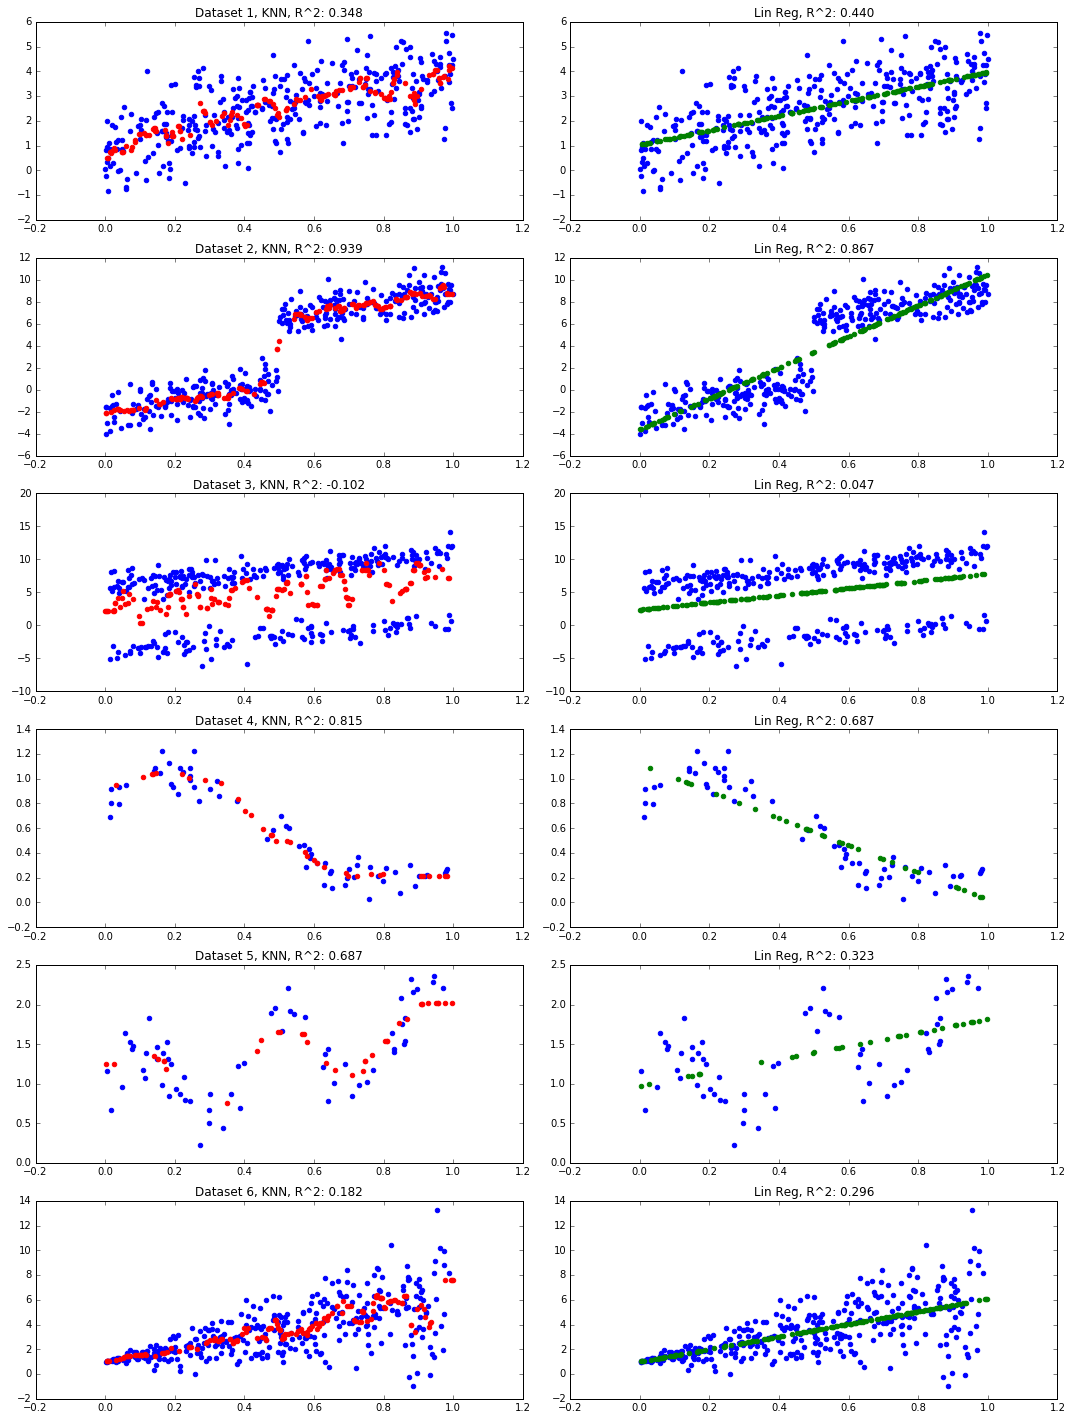

In [5]:
def scatter(ax, predicted_df, indices, color):
    ax.scatter(predicted_df.loc[indices]['x'],
               predicted_df.loc[indices]['y'],
               color=color)


def plot_ax(ax, predicted_df, dataset_data, no_ind_color, title):
    _, _, no_y_ind, with_y_ind = dataset_data
    scatter(ax, predicted_df, with_y_ind, 'blue')
    scatter(ax, predicted_df, no_y_ind, no_ind_color)
    ax.set_title(title)


def plot_missing(ax1, ax2, predicted_knn, r_knn, predicted_lin, r_lin, dataset_data, dataset_i):
    plot_ax(ax1, predicted_knn, dataset_data, 'red', 'Dataset %d, KNN, R^2: %.3f' % (dataset_i, r_knn))
    plot_ax(ax2, predicted_lin, dataset_data, 'green', 'Lin Reg, R^2: %.3f' % r_lin)


def get_dataset_data(dataset_i):
    # Read dataset i
    missing_df = pd.read_csv('./dataset/dataset_%d_missing.txt' % dataset_i)
    full_df = pd.read_csv('./dataset/dataset_%d_full.txt' % dataset_i)

    no_y_ind = missing_df[missing_df['y'].isnull()].index
    with_y_ind = missing_df[missing_df['y'].notnull()].index
    return missing_df, full_df, no_y_ind, with_y_ind


def handling_missing_data():
    # number of neighbours
    k = 10

    n_datasets = 6

    # plot predicted points
    fig, ax_pairs = plt.subplots(n_datasets, 2, figsize=(15, 3.3 * n_datasets))

    for dataset_i in range(1, n_datasets + 1):
        dataset_data = get_dataset_data(dataset_i)

        predicted_knn, r_knn = fill(KNN(n_neighbors=k), dataset_data)
        predicted_lin, r_lin = fill(Lin_Reg(), dataset_data)

        ax_pair = ax_pairs[dataset_i - 1]
        plot_missing(ax_pair[0], ax_pair[1],
                     predicted_knn, r_knn, predicted_lin,
                     r_lin, dataset_data, dataset_i)

    plt.tight_layout()
    plt.show()


handling_missing_data()

***Performance of KNN and linear regression in different cases***

Linear regression performs well when the underlying data is linear or close to it. On non-linear data linear regression has a high bias due to to its inflexibility and simplicity.

KNN performs better when there is local clear trend. KNN could work better on non-linear data than linear regression. KNN is a more flexible method than linear regression and it can have different degrees of flexibility for different values of k. But as a more flexible method it can have higher variance in certain situations.

Let's look at datasets.

Dataset 1. There is a clear linear trend with some noise around it. Linear regression worked quite well (R^2 = 0.44 vs 0.35 for KNN).

Dataset 2. Here we have two separate linear segments. They are close to each other so linear regression works relatively well (R^2 = 0.87) but KNN is able to adapt better (R^2 = 0.94).

Dataset 3. We have two separate parallel linear lines. Linear regression works quite well here considering the noise (R^2 = 0.05). KNN got confused by the noise (R^2 = -0.1), it has very high variance in this case.

Dataset 4. We have some non-linearity. Linear regression can capture some of its trend (R^2 = 0.69). But KNN can capture this non-linearity much better (R^2 = 0.82).

Dataset 5. Here we have highly non-linear trends. Linear regression gives us high bias here (R^2 = 0.32). KNN was able to adapt much better (R^2 = 0.69).

Dataset 6. One can say that we have a linear trend here with increase noise for higher x values ("fanning out"). As a result linear regression works better here (R^2 = 0.3) vs KNN (R^2 = 0.18). KNN has high variance here.

first k values:
[1, 2, 3, 4, 5]
[-0.06806030589259815, 0.18144929365297402, 0.25831028516255128, 0.34033483797058584, 0.3408527792189131]
max R^2: 0.430, k: 78


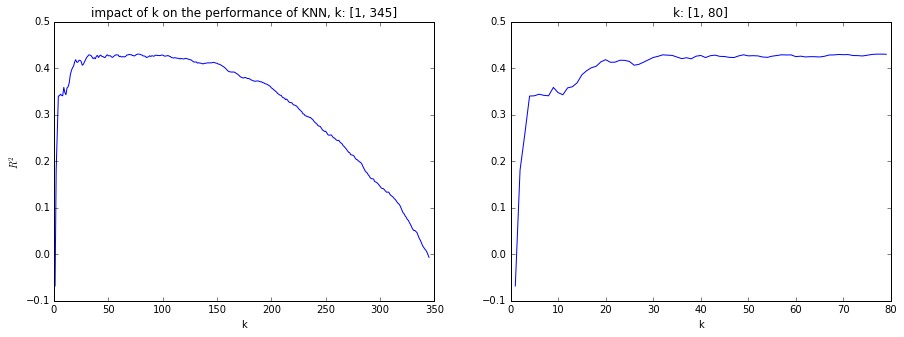

In [6]:
def impact_of_k_on_knn():
    dataset_data = get_dataset_data(1)
    k_list = []
    r_sq_list = []
    for k in range(1, 346):
        predicted_knn, r_knn = fill(KNN(n_neighbors=k), dataset_data)
        k_list.append(k)
        r_sq_list.append(r_knn)

    print 'first k values:'
    print k_list[:5]
    print r_sq_list[:5]

    max_r = max(r_sq_list)
    max_k = r_sq_list.index(max_r) + 1
    print 'max R^2: %.3f, k: %d' % (max_r, max_k)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(k_list, r_sq_list)
    ax1.set_xlabel('k')
    ax1.set_ylabel('$R^2$')
    ax1.set_title('impact of k on the performance of KNN, k: [1, 345]')

    ax2_k_start = 0
    ax2_k_limit = 79
    ax2.plot(k_list[ax2_k_start:ax2_k_limit], r_sq_list[ax2_k_start:ax2_k_limit])
    ax2.set_xlabel('k')
    ax2.set_title('k: [%d, %d]' % (ax2_k_start + 1, ax2_k_limit + 1))

    plt.show()

    
impact_of_k_on_knn()

***Impact of k on the performance of KNN***

Here we look at dataset_1_missing.txt. On the left we have a plot of all values of k (1 to 345). On the right it's k values 1 to 60. 

We see that at low values for k (1 to 3), the method is too flexible and gives us low R^2 values (-0.07 to 0.29). Then it improves to around 0.4 at k = 20, peaks at 0.43 (k = 78). And at around k = 120 R^2 values start to drop slowly due to lower flexibility and worse fit.

---

## Problem 3: Is the Best (Linear Model) Good Enough?

In this problem, we will specifically look at conditions under which linear regression excels or fails.

The datasets required for this problem is in the ``dataset`` directory. Each file in the ``dataset`` directory contains a one-dimensional data set, with the first column containing the independent variable X, and the second column containing the dependent variable Y.

### Part (a): Introduction to Residual Plots

- Read ``dataset_1_full.txt``. Visualize the dataset and make some initial observations.


- For this data set, what can you say about the following linear fits: 

    1. slope = 0.4, intercept = 0.2
    2. slope = 0.4, intercept = 4
    3. linear regression model


- In each case, visualize the fit, compute the residuals, and make a residual plot of predicted values along with  residuals, as well as a residual histogram. What do these plots reveal?  


- Calculate the R^2 coefficient for all three fits. What do the errors reveal? How do they compare to the residual plots?

**Solution:**

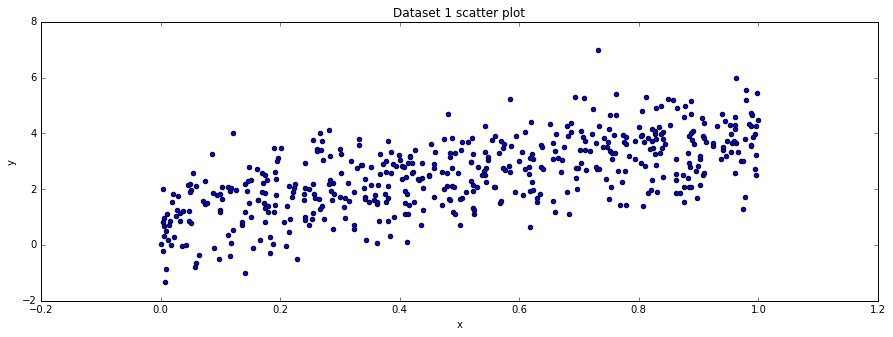

In [7]:
Problem_3_Data = namedtuple('Problem_3_Data', ['df', 'lin_reg_fit', 'fit_info_list'])
LinearFit = namedtuple('LinearFit', ['slope', 'intercept'])
FitInfo = namedtuple('FitInfo', ['linear_fit', 'title'])


def read_dataset(dataset_i):
    return pd.read_csv('./dataset/dataset_%d_full.txt' % dataset_i)


def reshape_column(df, column_name):
    return df[column_name].reshape(-1, 1)


def prepare_problem_3_data(dataset_i):
    df = read_dataset(dataset_i)
    x_train = reshape_column(df, 'x')
    y_train = reshape_column(df, 'y')
    lin_reg = Lin_Reg()
    lin_reg.fit(x_train, y_train)
    lin_reg_fit = LinearFit(lin_reg.coef_[0][0], lin_reg.intercept_[0])
    fit_info_list = [
        FitInfo(LinearFit(0.4, 0.2), 'slope = 0.4, intercept = 0.2'),
        FitInfo(LinearFit(0.4, 4.0), 'slope = 0.4, intercept = 4'),
        FitInfo(lin_reg_fit, 'linear regression model'),
    ]
    return Problem_3_Data(df, lin_reg_fit, fit_info_list)


def read_and_visualize_dataset():
    df = problem_3a_data.df

    fig, ax1 = plt.subplots(1, 1, figsize=(15, 5))
    ax1.scatter(df[['x']].values, df[['y']].values)
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_title('Dataset 1 scatter plot')
    plt.show()

    
problem_3a_data = prepare_problem_3_data(1)
read_and_visualize_dataset()

***Initial observations***

We can see a linear trend with some noise around it.

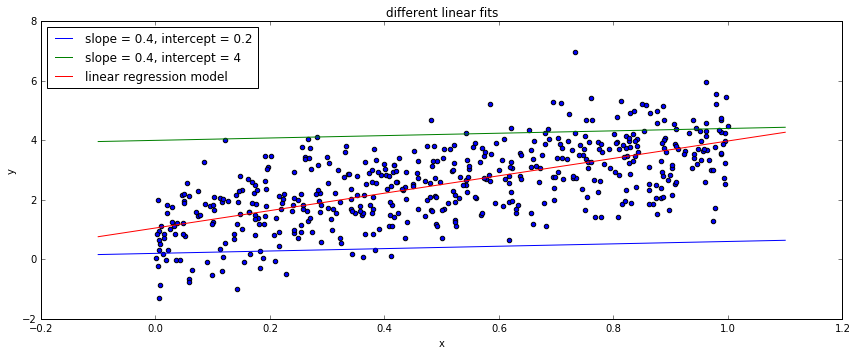

In [8]:
def visualize_fit():
    df = problem_3a_data.df
    lin_reg_fit = problem_3a_data.lin_reg_fit

    x_values = df['x']
    y_values = df['y'].values

    fig, ax = plt.subplots(1, 1, figsize=(12, 5))

    ax.scatter(x_values, y_values)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('different linear fits')

    x = np.arange(-0.1, 2.0, step=1.2)
    ax.plot(x, 0.4 * x + 0.2, label='slope = 0.4, intercept = 0.2')
    ax.plot(x, 0.4 * x + 4, label='slope = 0.4, intercept = 4')
    ax.plot(x, lin_reg_fit.slope * x + lin_reg_fit.intercept, label='linear regression model')
    ax.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

    
visualize_fit()

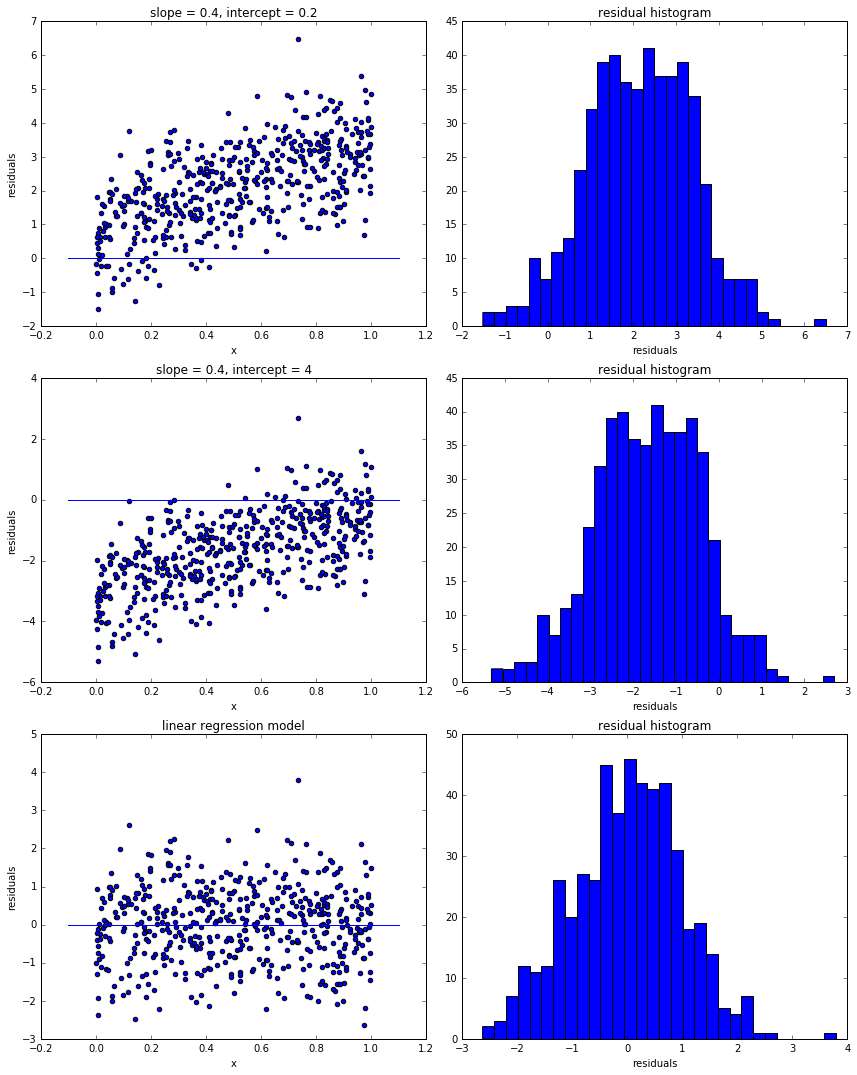

In [9]:
def compute_residuals(x_values, y_values, linear_fit):
    residuals = []
    for x, y in izip(x_values, y_values):
        residuals.append(y - (x * linear_fit.slope + linear_fit.intercept))
    return residuals


def residual_plots():
    df = problem_3a_data.df

    x_values = df['x']
    y_values = df['y']

    fig, axes = plt.subplots(3, 2, figsize=(12, 15))

    for i, fit_info in enumerate(problem_3a_data.fit_info_list):
        ax1 = axes[i][0]
        residuals = compute_residuals(x_values, y_values, fit_info.linear_fit)
        ax1.scatter(x_values, residuals)
        ax1.set_xlabel('x')
        ax1.set_ylabel('residuals')
        ax1.set_title(fit_info.title)
        ax1.plot((-0.1, 1.1), (0, 0))

        ax2 = axes[i][1]
        ax2.hist(residuals, 30)
        ax2.set_xlabel('residuals')
        ax2.set_title('residual histogram')

    plt.tight_layout()
    plt.show()


residual_plots()

***What do these plots reveal?***

The residual plots for the first two fits can tell us that these fits are not good. They are not uniformly centered around zero. The residuals both have pattern - a band with a positive slope.
Only the linear regression looks good. It's centered around zero. The residuals form a horizontal band.
It's more difficult to judge using histograms. And even in this case the linear regression histogram looks close to a regular normal distribution that we are looking for.

In [10]:
def calculate_r_squared_coef(x_values, y_values, linear_fit):
    rss = 0.0
    tss = 0.0
    y_mean = y_values.mean()
    for x, y in izip(x_values, y_values):
        y_hat = x * linear_fit.slope + linear_fit.intercept
        rss += (y - y_hat) ** 2
        tss += (y - y_mean) ** 2
    return 1.0 - rss / tss


def calculate_r_squared_coefs():
    df = problem_3a_data.df
    x_values = df['x']
    y_values = df['y']
    for fit_info in problem_3a_data.fit_info_list:
        print '%s:\nR^2 = %.3f' % (fit_info.title, calculate_r_squared_coef(x_values, y_values, fit_info.linear_fit))

        
calculate_r_squared_coefs()

slope = 0.4, intercept = 0.2:
R^2 = -2.544
slope = 0.4, intercept = 4:
R^2 = -1.497
linear regression model:
R^2 = 0.431


***R^2 coefficient***

The best R^2 coefficient (0.431) is for the linear regression model (as expected). The other two are less than zero which means they are worse than the model where we predict y_mean for every x value. We can see it in the residual plots where the overwhelming  majority of the residuals are on one side of the zero line.

### Part (b): What do Residual Plots Reveal?

- Read datasets ``dataset_2_full.txt`` through ``dataset_6_full.txt``. In each case, visualize the fit, compute the residuals, and make a residual plot of predicted values along with  residuals, as well as a residual histogram. What do these plots reveal about the fit of the model? 


- Calculate the R^2 coefficient each fit. What do the erors reveal? How do they compare to the residual plots?


- Based on your analysis, form conjectures regarding the precise relationship between the residual plots and the fit of the linear regression model. Conjecture on the precise conditions under which linear regression model is an appropriate model for a given dataset.

**Solution:**

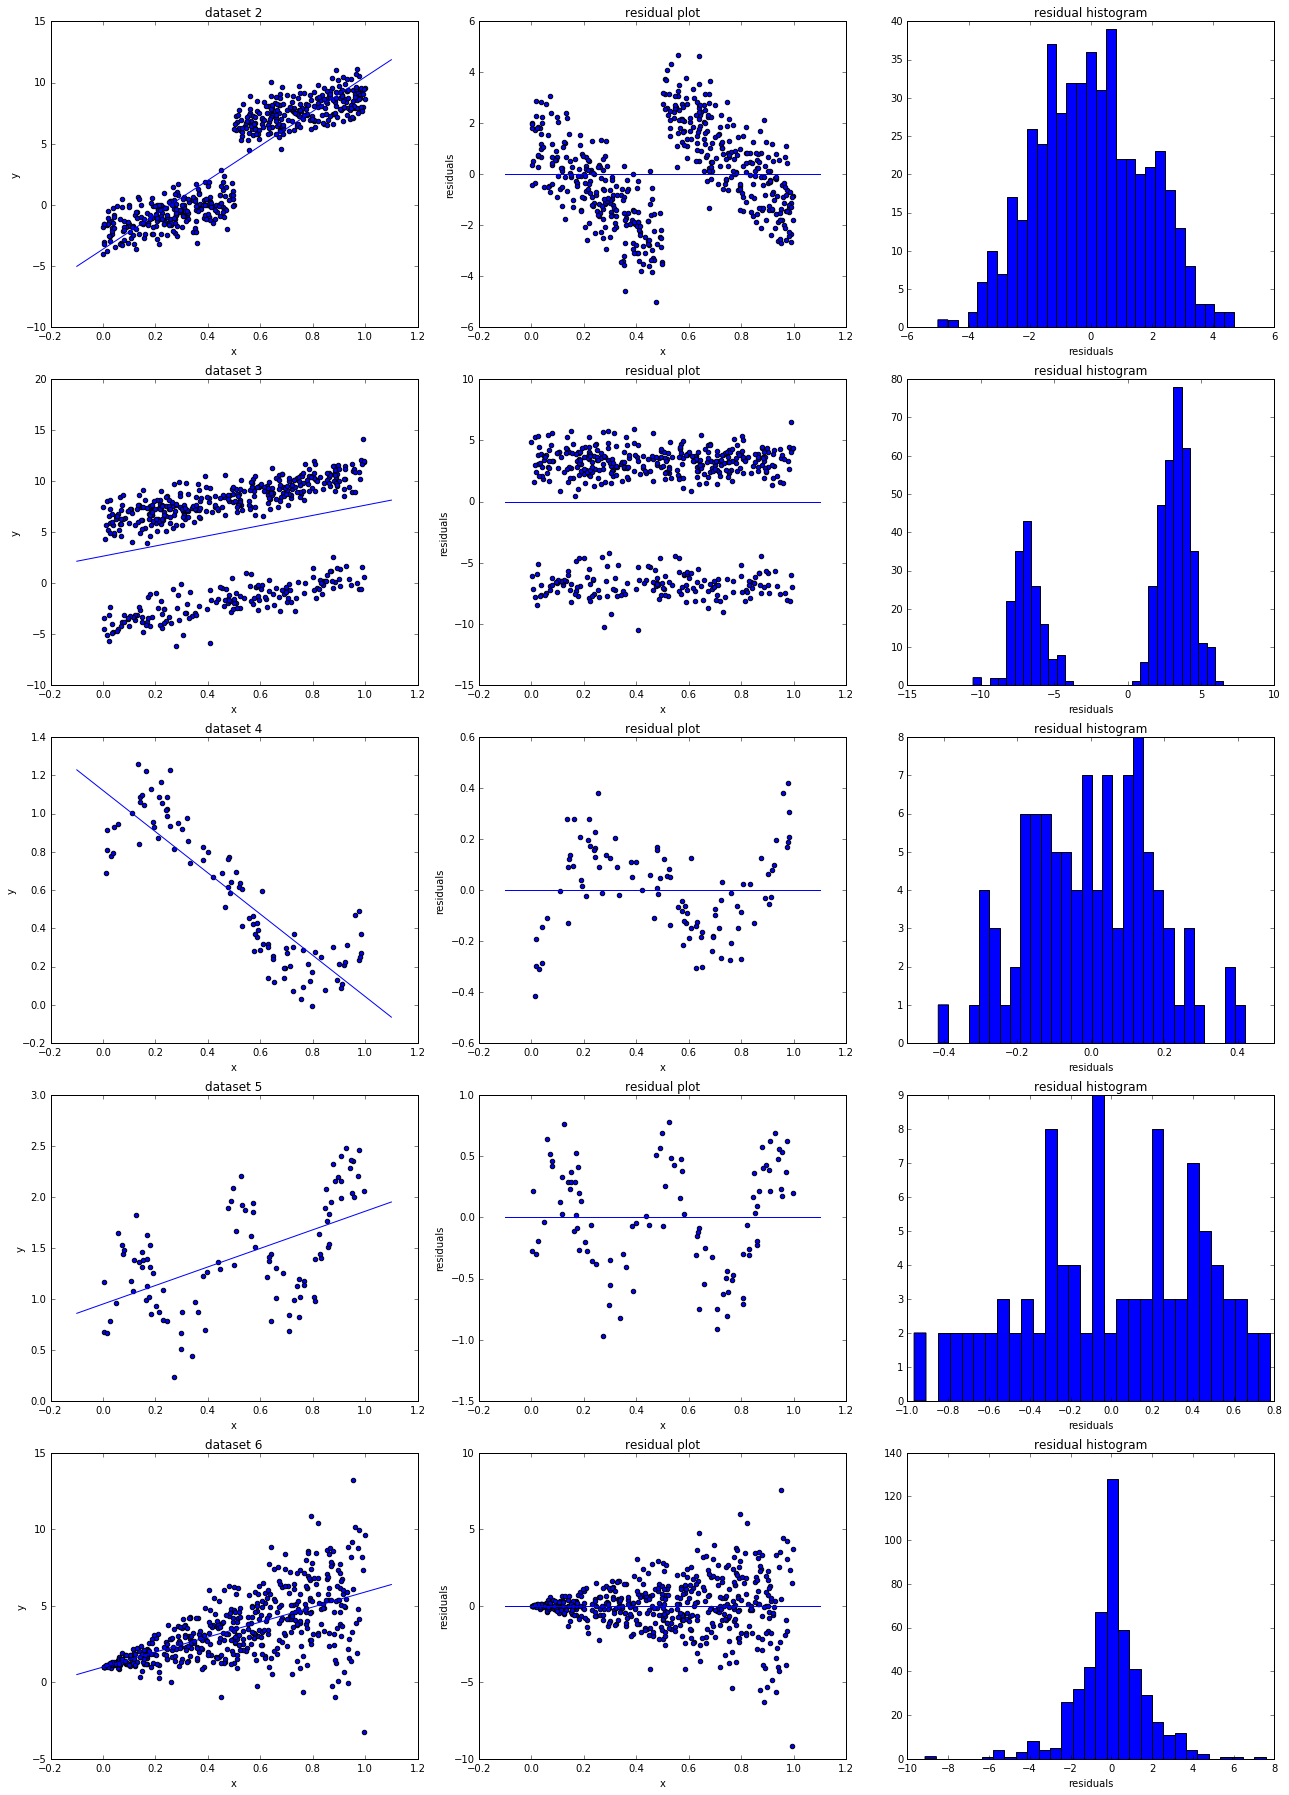

In [11]:
def residual_plots_for_other_datasets():
    fig, ax_pairs = plt.subplots(5, 3, figsize=(6 * 3, 5 * 5))

    for i in range(2, 7):
        problem_3_data = prepare_problem_3_data(i)
        ax_pair = ax_pairs[i - 2]

        df = problem_3_data.df
        lin_reg_fit = problem_3_data.lin_reg_fit

        x_values = df['x']
        y_values = df['y']

        ax1 = ax_pair[0]
        ax1.scatter(x_values, y_values)
        ax1.set_xlabel('x')
        ax1.set_ylabel('y')
        ax1.set_title('dataset %d' % i)

        x = np.arange(-0.1, 2.0, step=1.2)
        ax1.plot(x, lin_reg_fit.slope * x + lin_reg_fit.intercept)

        residuals = compute_residuals(x_values, y_values, lin_reg_fit)
        ax2 = ax_pair[1]
        ax2.scatter(x_values, residuals)
        ax2.set_xlabel('x')
        ax2.set_ylabel('residuals')
        ax2.set_title('residual plot')
        ax2.plot((-0.1, 1.1), (0, 0))

        ax3 = ax_pair[2]
        ax3.hist(residuals, 30)
        ax3.set_xlabel('residuals')
        ax3.set_title('residual histogram')

    plt.tight_layout()
    plt.show()

    
residual_plots_for_other_datasets()

***What do these plots reveal about the fit of the model?***

In all residual plots we see various patterns. And almost all histograms (except maybe for dataset 2) don't exhibit a bell-shaped histogram typical for a normal distribution. All of this tells us that a linear regression fit will be flawed to some degree for all of these datasets and not a good model. And the main reason is some form of non-linearity in the underlying model.

In [12]:
def r_squared_coef_for_other_datasets():
    for i in range(2, 7):
        problem_3_data = prepare_problem_3_data(i)
        df = problem_3_data.df
        x_values = df['x']
        y_values = df['y']
        lin_reg_fit = problem_3_data.lin_reg_fit
        print 'dataset %d, R^2 = %.3f' % (i, calculate_r_squared_coef(x_values, y_values, lin_reg_fit))

        
r_squared_coef_for_other_datasets()

dataset 2, R^2 = 0.843
dataset 3, R^2 = 0.078
dataset 4, R^2 = 0.758
dataset 5, R^2 = 0.298
dataset 6, R^2 = 0.383


***R^2 coefficients***

All of these R^2 coefficients are negative which tells us that the linear fit is worse than the constant fit where every prediction equals the mean of all y values in the dataset. It's another indication that the linear regression model is not a good model for these datasets.

***Relationship between the residual plots and the fit of the linear regression model***



---

## Challenge Problem: Combining Random Variables

This problem, we explore the distirbution of random variables that result from combining other random variables.

### Part (a): Adding Two Uniformly Distributed Variables

Consider the independent random variables $X\sim U(0, 1)$ and $Y\sim U(0, 1)$. Let $Z$ be the random variable $Z = X + Y$. 

What is the distribution of $Z$ (give the pdf for Z)? You should fully explain and support your conlusion. 

**Hint:** your solution can be a combination of experimentation, empirical evidence and/or algebra

**Solution:**

### Part (b): Adding Multiple Uniformly Distributed Variables

Consider three independent random variables $X_1, X_2, X_3 \sim U(0, 1)$. Let $Z$ be the random variable $Z = X_1 + X_2 + X_3$. 

What is the distribution of $Z$? What if you add 10 or 12 independent (standard) uniformly distributed variables? Conjecture on the distribution of 
$$
Z = \lim_{n\to \infty} \sum_{i=1}^n X_i
$$
where $\left\{X_i \right\}$ are independent (standard) uniformly distributed variables.

**Hint:** your solution can be a combination of experimentation, empirical evidence and/or algebra

**Solution:**

### Part (c): Combining Normally Distributed Variables

Consider the independent random variables $X\sim \mathcal{N}(0, 1)$ and $Y\sim \mathcal{N}(0, 1)$. Let $Z$ be the random variable $Z = X + Y$. 

What is the distribution of $Z$ (give the pdf for Z)? You should fully explain and support your conlusion. 

**Hint:** use properties of expected value and some experimentation.

**Solution:**

### Part (d): Product of Normally Distributed Variables

Is the product of two normally distributed variables a normally distributed variable? You should fully explain and support your conlusion. 

**Solution:**

---